In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Load and preprocess the dataset
df = pd.read_csv('all_buildings_data.csv')

# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0', 'building'])

# Extract features (aggregate power) and targets (appliance power consumption)
X = df['aggregate'].values.reshape(-1, 1)
y = df.drop(columns=['aggregate']).values  # All appliance columns as targets

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Standardize targets
y = scaler.fit_transform(y)

# Create windows of data
def create_windows(data, targets, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(targets[i + window_size])
    return np.array(X), np.array(y)

window_size = 60  # 60 points of time in our window

# Prepare the data
X, y = create_windows(X, y, window_size)

# Reshape X for Conv1D input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the multi-output Seq2Point model
def multi_output_seq2point_model(input_shape, num_outputs):
    model = Sequential()
    model.add(Conv1D(16, 10, activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv1D(32, 7, activation='relu', padding='same'))
    model.add(Conv1D(64, 5, activation='relu', padding='same'))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_outputs))  # Linear activation (default) for regression output
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model



# Create the model
num_appliances = y_train.shape[1]
model = multi_output_seq2point_model((X_train.shape[1], 1), num_appliances)
# Model summary
print (model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 60, 16)              │             176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 60, 32)              │           3,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 60, 64)              │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 60, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 7680)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       7,865,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 31)                  │          31,775 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,935,919 (30.27 MB)

 Trainable params: 7,935,919 (30.27 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Model Mean Absolute Error: {mae}')

Epoch 1/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 0.5739 - mae: 0.4260 - val_loss: 0.4694 - val_mae: 0.3686
Epoch 2/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.4751 - mae: 0.3631 - val_loss: 0.4463 - val_mae: 0.3620
Epoch 3/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.4245 - mae: 0.3451 - val_loss: 0.4266 - val_mae: 0.3461
Epoch 4/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.3945 - mae: 0.3288 - val_loss: 0.4143 - val_mae: 0.3370
Epoch 5/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.3502 - mae: 0.3174 - val_loss: 0.4086 - val_mae: 0.3359
Epoch 6/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.3201 - mae: 0.3066 - val_loss: 0.4022 - val_mae: 0.3294
Epoch 7/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.2908 - mae: 0.2944 - val_loss: 0.3994 - val_mae: 0.3283
Epoch 8/50
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.2752 - mae: 0.2851 - val_loss: 0.4012 - val_mae: 0.3294
Epoch 9/50
1785/1785 ━━━━━━━━━━━━━━━

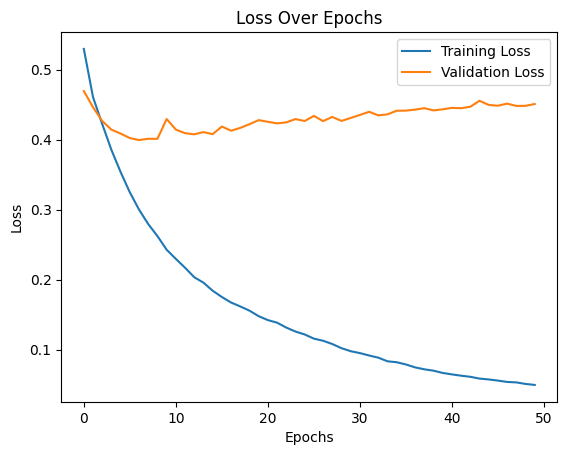

In [ ]:
# Loss Over epochs plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

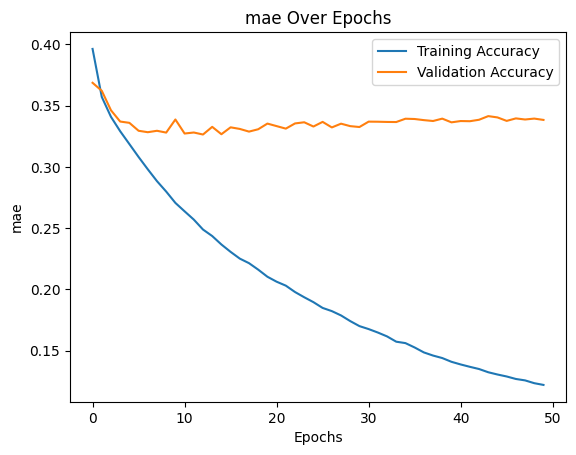

In [ ]:
# MAE Over epochs Plot
plt.plot(history.history['mae'], label='Training Accuracy')
plt.plot(history.history['val_mae'], label='Validation Accuracy')
plt.title('mae Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

In [ ]:
# List of appliance names
appliances = [
    'laptop computer', 'television', 'light', 'HTPC', 'food processor', 'toasted sandwich maker',
    'toaster', 'microwave', 'computer monitor', 'audio system', 'audio amplifier', 'broadband router',
    'ethernet switch', 'USB hub', 'tablet computer charger', 'radio', 'wireless phone charger', 'mobile phone charger',
    'coffee maker', 'computer', 'external hard disk', 'desktop computer', 'printer', 'immersion heater',
    'security alarm', 'projector', 'server computer', 'running machine', 'network attached storage', 'fridge',
    'air conditioner'
]


# Function to predict appliance consumption from aggregate
def predict_appliance_consumption(aggregate_window, scaler, window_size):
    # Standardize the input features
    aggregate_window = np.array(aggregate_window).reshape(-1, 1)
    aggregate_window = scaler.fit_transform(aggregate_window)
    aggregate_window = aggregate_window.reshape((1, window_size, 1))

    # Predict using the trained model
    predictions = model.predict(aggregate_window)
    # Clip negative values to zero
    predictions = np.clip(predictions, 0, None)
    return predictions

# Example usage (a new window of aggregate power consumption data)
aggregate_window = [
    100, 52.31, 1.0, 135.28, 2.0, 1.0, 1.0, 0.0, 1.0, 4.89, 51.10, 0.0, 6.0,
    51.44, 51.44, 50.52, 135.28, 1.0, 0.0, 0.0, 13.88, 13.88, 57.26, 50.93,
    102.20, 102.20, 135.28, 135.28, 135.28, 135.28, 0.0, 135.28, 99.8, 98.7,
    102.3, 101.2, 100.5, 102.0, 105.0, 99.9, 98.4, 102.1, 101.3, 100.4, 100.7,
    102.8, 101.5, 100.3, 101.7, 100.9, 102.2, 100.6, 99.5, 101.4, 100.2, 100.1,
    99.6, 98.5, 100.0, 99.7
]

predictions = predict_appliance_consumption(aggregate_window, scaler, window_size)


# Map appliance names to their predicted consumption values
predicted_consumption = dict(zip(appliances, predictions[0]))

print("Predicted appliance consumption:")
for appliance, consumption in predicted_consumption.items():
    print(f"{appliance}: {consumption}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Predicted appliance consumption:
laptop computer: 0.0
television: 5.479945659637451
light: 0.0
HTPC: 0.6873762011528015
food processor: 0.09896597266197205
toasted sandwich maker: 0.09978656470775604
toaster: 0.0
microwave: 0.4883067011833191
computer monitor: 0.0
audio system: 0.0
audio amplifier: 1.4185189008712769
broadband router: 0.0
ethernet switch: 0.0
USB hub: 0.0
tablet computer charger: 0.0
radio: 0.0
wireless phone charger: 0.0
mobile phone charger: 0.0
coffee maker: 0.0
computer: 0.0
external hard disk: 0.0
desktop computer: 0.0
printer: 0.0
immersion heater: 0.576664924621582
security alarm: 0.5769802331924438
projector: 0.0
server computer: 0.0
running machine: 0.0
network attached storage: 0.0
fridge: 3.326725482940674
air conditioner: 0.0


In [ ]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

558/558 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean Absolute Error (MAE): 0.3386506900203716
Mean Squared Error (MSE): 0.4859244264913531
R-squared (R²): 0.5244786016862649
